In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_singlegrid_half'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 15 x 45


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f9c87f1b2e8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f9c89b2f5f8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.71 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.705    |
| time/              |          |
|    fps             | 367      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 36 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.693      |
| time/                   |            |
|    fps                  | 386        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |       

policy iteration runtime: 28 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.74        |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.053068973 |
|    clip_fraction        | 0.484       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.02        |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0618     |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0453     |
|    std                  | 

policy iteration runtime: 28 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.751       |
| time/                   |             |
|    fps                  | 382         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.052461974 |
|    clip_fraction        | 0.538       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.29        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00154     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0477     |
|    std                  | 

policy iteration runtime: 29 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.763      |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05034511 |
|    clip_fraction        | 0.546      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.43       |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0598    |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0446    |
|    std                  | 0.178      |
|    value_loss           |

policy iteration runtime: 27 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.775      |
| time/                   |            |
|    fps                  | 391        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06947879 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.76       |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0543    |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.0428    |
|    std                  | 0.176      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.789       |
| time/                   |             |
|    fps                  | 374         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.063024774 |
|    clip_fraction        | 0.578       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.23        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0448     |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0405     |
|    std                  | 0.172       |
|    va

policy iteration runtime: 27 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.799      |
| time/                   |            |
|    fps                  | 383        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07693562 |
|    clip_fraction        | 0.587      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.47       |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00878    |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0389    |
|    std                  | 0.17       |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.812     |
| time/                   |           |
|    fps                  | 393       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0748721 |
|    clip_fraction        | 0.587     |
|    clip_range           | 0.15      |
|    entropy_loss         | 8.07      |
|    explained_variance   | 0.973     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0344   |
|    n_updates            | 1140      |
|    policy_gradient_loss | -0.0353   |
|    std                  | 0.165     |
|    value_loss          

policy iteration runtime: 28 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.819      |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08844456 |
|    clip_fraction        | 0.601      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.77       |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00643    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.031     |
|    std                  | 0.161      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 392        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10004294 |
|    clip_fraction        | 0.609      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.31       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0894    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0306    |
|    std                  | 0.157      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.099382386 |
|    clip_fraction        | 0.615       |
|    clip_range           | 0.15        |
|    entropy_loss         | 9.87        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0937     |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0272     |
|    std                  |

policy iteration runtime: 29 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.835       |
| time/                   |             |
|    fps                  | 392         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088201836 |
|    clip_fraction        | 0.635       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.3        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0533     |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0238     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.841      |
| time/                   |            |
|    fps                  | 399        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07203456 |
|    clip_fraction        | 0.62       |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.9       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0646    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0253    |
|    std                  | 0.146      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.842       |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.102905646 |
|    clip_fraction        | 0.637       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.5        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0669     |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0219     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 389        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09867485 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0229    |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.0228    |
|    std                  | 0.139      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 400        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10925269 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.4       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0717    |
|    n_updates            | 2420       |
|    policy_gradient_loss | -0.0172    |
|    std                  | 0.136      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 390        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12054002 |
|    clip_fraction        | 0.652      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.9       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0578    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0195    |
|    std                  | 0.133      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 389        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12199205 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.112      |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0167    |
|    std                  | 0.13       |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 392        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11183367 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.7       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0111    |
|    n_updates            | 2900       |
|    policy_gradient_loss | -0.0166    |
|    std                  | 0.128      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 78336

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 383        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13137522 |
|    clip_fraction        | 0.658      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0515    |
|    n_updates            | 3060       |
|    policy_gradient_loss | -0.0141    |
|    std                  | 0.126      |
|    value_loss           |

policy iteration runtime: 27 seconds

Total episode rollouts: 82432

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 398        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13592868 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0336    |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0164    |
|    std                  | 0.125      |
|    value_loss           |

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 31 seconds

Total episode rollouts: 86528

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 392        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15204717 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.4       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0444    |
|    n_updates            | 3380       |
|    policy_gradient_loss | -0.0105    |
|    std     

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 26 seconds

Total episode rollouts: 90624

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 373        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15125284 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0184     |
|    n_updates            | 3540       |
|    policy_gradient_loss | -0.0

Early stopping at step 19 due to reaching max kl: 0.16
policy iteration runtime: 28 seconds

Total episode rollouts: 94720

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 391        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15753333 |
|    clip_fraction        | 0.682      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0527    |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.0143    |
|    std     

Early stopping at step 8 due to reaching max kl: 0.15
policy iteration runtime: 15 seconds

Total episode rollouts: 98816

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 385        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15324652 |
|    clip_fraction        | 0.651      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00849   |
|    n_updates            | 3860       |
|    policy_gradient_loss | 0.0116     |
|    std      

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 21 seconds

Total episode rollouts: 102912

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15000488 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0761     |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 23 seconds

Total episode rollouts: 107008

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 390        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15452668 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0381    |
|    n_updates            | 4180       |
|    policy_gradient_loss | -0.00938   |
|    std    

policy iteration runtime: 29 seconds

Total episode rollouts: 111104

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 389        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14614637 |
|    clip_fraction        | 0.679      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0635    |
|    n_updates            | 4340       |
|    policy_gradient_loss | -0.00992   |
|    std                  | 0.117      |
|    value_loss           

Early stopping at step 19 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 115200

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 390        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15136549 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0664     |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.00756   |
|    std    

Early stopping at step 10 due to reaching max kl: 0.15
policy iteration runtime: 20 seconds

Total episode rollouts: 119296

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 400        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15183067 |
|    clip_fraction        | 0.669      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0921     |
|    n_updates            | 4660       |
|    policy_gradient_loss | 0.00524    |
|    std    

Early stopping at step 9 due to reaching max kl: 0.16
policy iteration runtime: 21 seconds

Total episode rollouts: 123392

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16485476 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0537    |
|    n_updates            | 4820       |
|    policy_gradient_loss | 0.00

Early stopping at step 9 due to reaching max kl: 0.16
policy iteration runtime: 19 seconds

Total episode rollouts: 127488

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 391        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15542054 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00592   |
|    n_updates            | 4980       |
|    policy_gradient_loss | 0.00387    |
|    std     

Early stopping at step 11 due to reaching max kl: 0.16
policy iteration runtime: 21 seconds

Total episode rollouts: 131584

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.85      |
| time/                   |           |
|    fps                  | 387       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1588045 |
|    clip_fraction        | 0.667     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.8      |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.0001    |
|    loss                 | 0.037     |
|    n_updates            | 5140      |
|    policy_gradient_loss | 0.00756   |
|    std 

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 135680

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.85      |
| time/                   |           |
|    fps                  | 382       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1545641 |
|    clip_fraction        | 0.672     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.7      |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0164   |
|    n_updates            | 5300      |
|    policy_gradient_loss | 0.00294   |
|    std                  | 0.1

Early stopping at step 13 due to reaching max kl: 0.16
policy iteration runtime: 25 seconds

Total episode rollouts: 139776

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 396        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16325217 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0183    |
|    n_updates            | 5460       |
|    policy_gradient_loss | 0.000744   |
|    std    

Early stopping at step 14 due to reaching max kl: 0.16
policy iteration runtime: 22 seconds

Total episode rollouts: 143872

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 395        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15671961 |
|    clip_fraction        | 0.686      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0847     |
|    n_updates            | 5620       |
|    policy_gradient_loss | -0.00626   |
|    std    

policy iteration runtime: 27 seconds

Total episode rollouts: 147968

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 398        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14330569 |
|    clip_fraction        | 0.693      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0332     |
|    n_updates            | 5780       |
|    policy_gradient_loss | -0.00957   |
|    std                  | 0.116      |
|    value_loss           

<IPython.core.display.Javascript object>


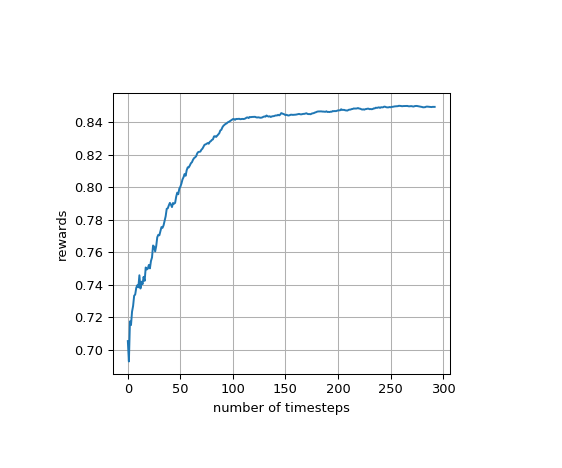

Using cuda device
seed 2: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 15 x 45


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f9c89b0dda0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f9c14354940>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.693      |
| time/                   |            |
|    fps                  | 360        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15289764 |
|    clip_fraction        | 0.682      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0504    |
|    n_updates            | 5860       |
|    policy_gradient_loss | -0.00798   |
|    std                  | 0.116      |
|    value_loss           | 0.000563   |
---------------------------------

policy iteration runtime: 27 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.734      |
| time/                   |            |
|    fps                  | 399        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05016265 |
|    clip_fraction        | 0.492      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.03       |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0178    |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0459    |
|    std                  | 0.182      |
|    value_loss           | 

policy iteration runtime: 28 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.746       |
| time/                   |             |
|    fps                  | 395         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.051667236 |
|    clip_fraction        | 0.513       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.18        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0889     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0451     |
|    std                  | 0.18        |
|    val

policy iteration runtime: 27 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.753      |
| time/                   |            |
|    fps                  | 380        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05869348 |
|    clip_fraction        | 0.528      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.62       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0573    |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0451    |
|    std                  | 0.177      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.761       |
| time/                   |             |
|    fps                  | 389         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.054327942 |
|    clip_fraction        | 0.558       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.9         |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0576     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0434     |
|    std                  | 0.174       |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.764      |
| time/                   |            |
|    fps                  | 390        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07318449 |
|    clip_fraction        | 0.57       |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.22       |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.078     |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0427    |
|    std                  | 0.172      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.78        |
| time/                   |             |
|    fps                  | 389         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088641696 |
|    clip_fraction        | 0.588       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.57        |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0608     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0374     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.8        |
| time/                   |            |
|    fps                  | 401        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06922829 |
|    clip_fraction        | 0.593      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8          |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00504    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0362    |
|    std                  | 0.166      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.808       |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.074870646 |
|    clip_fraction        | 0.605       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.46        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.103      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0354     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.816      |
| time/                   |            |
|    fps                  | 387        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08299084 |
|    clip_fraction        | 0.62       |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.86       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0301    |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0307    |
|    std                  | 0.16       |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.823      |
| time/                   |            |
|    fps                  | 396        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07558352 |
|    clip_fraction        | 0.619      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.21       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0269    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0254    |
|    std                  | 0.157      |
|    

policy iteration runtime: 29 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.834       |
| time/                   |             |
|    fps                  | 386         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.086456016 |
|    clip_fraction        | 0.627       |
|    clip_range           | 0.15        |
|    entropy_loss         | 9.79        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.035      |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0245     |
|    std                  |

policy iteration runtime: 31 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.841      |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07972409 |
|    clip_fraction        | 0.628      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.4       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0255    |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0212    |
|    std                  | 0.149      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.843     |
| time/                   |           |
|    fps                  | 393       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0863475 |
|    clip_fraction        | 0.618     |
|    clip_range           | 0.15      |
|    entropy_loss         | 11        |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.0001    |
|    loss                 | 0.00338   |
|    n_updates            | 2080      |
|    policy_gradient_loss | -0.0156   |
|    std                  | 0.145     |
|    value_loss          

policy iteration runtime: 27 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.120152116 |
|    clip_fraction        | 0.611       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.4        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0188      |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0115     |
|    std                  | 0.142       |
|    va

policy iteration runtime: 29 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 397        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11145978 |
|    clip_fraction        | 0.635      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0274    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0149    |
|    std                  | 0.139      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 389        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11924921 |
|    clip_fraction        | 0.642      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00146   |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0151    |
|    std                  | 0.137      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11448791 |
|    clip_fraction        | 0.64       |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.7       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0184     |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.134      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10955851 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.2       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0597    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.00978   |
|    std                  | 0.132      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 378        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12763895 |
|    clip_fraction        | 0.646      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.2       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0308    |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.0108    |
|    std                  | 0.132      |
|    value_loss           |

policy iteration runtime: 30 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13856693 |
|    clip_fraction        | 0.647      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.3       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.000824  |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.131      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.852       |
| time/                   |             |
|    fps                  | 396         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.124265775 |
|    clip_fraction        | 0.658       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.4        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00698     |
|    n_updates            | 3360        |
|    policy_gradient_loss | -0.00828    |
|    std                  | 0.131       |
|    va

policy iteration runtime: 27 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 377        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14740388 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0446     |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.00845   |
|    std                  | 0.13       |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 392        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10776268 |
|    clip_fraction        | 0.674      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.8       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00473   |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.00539   |
|    std                  | 0.129      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 379        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13203137 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0602    |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.0101    |
|    std                  | 0.128      |
|    value_loss           |

policy iteration runtime: 30 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13304953 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00192   |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.00669   |
|    std                  | 0.127      |
|    value_loss           

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 26 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15172999 |
|    clip_fraction        | 0.651      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00518   |
|    n_updates            | 4160       |
|    policy_gradient_loss | 6.5

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 23 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15050992 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0237    |
|    n_updates            | 4320       |
|    policy_gradient_loss | 0.0

Early stopping at step 11 due to reaching max kl: 0.17
policy iteration runtime: 24 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.855     |
| time/                   |           |
|    fps                  | 388       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1690654 |
|    clip_fraction        | 0.653     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.2      |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0207   |
|    n_updates            | 4480      |
|    policy_gradient_loss | 0.00656   |
|    std 

Early stopping at step 19 due to reaching max kl: 0.16
policy iteration runtime: 27 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16380903 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0612     |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.00528   |
|    std    

policy iteration runtime: 28 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13317876 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.057     |
|    n_updates            | 4800       |
|    policy_gradient_loss | 0.000922   |
|    std                  | 0.127      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.16
policy iteration runtime: 27 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 381        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15770888 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.096      |
|    n_updates            | 4960       |
|    policy_gradient_loss | 0.0041     |
|    std    

policy iteration runtime: 28 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 394        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12104823 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.108      |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.000331  |
|    std                  | 0.127      |
|    value_loss           

policy iteration runtime: 35 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.856       |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.123301685 |
|    clip_fraction        | 0.676       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.2        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0383      |
|    n_updates            | 5280        |
|    policy_gradient_loss | -0.00743    |
|    std                  | 0.127       |
|    v

policy iteration runtime: 27 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 378        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13918844 |
|    clip_fraction        | 0.678      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.121      |
|    n_updates            | 5440       |
|    policy_gradient_loss | -0.00993   |
|    std                  | 0.127      |
|   

policy iteration runtime: 28 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 378        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13946006 |
|    clip_fraction        | 0.684      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.4       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0268     |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.00813   |
|    std                  | 0.126      |
|    value_loss           

Early stopping at step 10 due to reaching max kl: 0.16
policy iteration runtime: 21 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 371        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15506239 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0818     |
|    n_updates            | 5760       |
|    policy_gradient_loss | 0.0088     |
|    std    

<IPython.core.display.Javascript object>


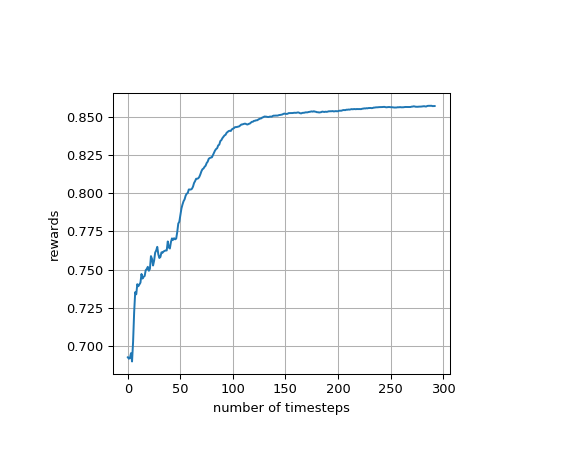

Using cuda device
seed 3: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 15 x 45


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f9c142fb518> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f9c142a2240>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.696     |
| time/                   |           |
|    fps                  | 379       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1523191 |
|    clip_fraction        | 0.676     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.8      |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0317   |
|    n_updates            | 5860      |
|    policy_gradient_loss | -7.74e-05 |
|    std                  | 0.123     |
|    value_loss           | 0.000325  |
---------------------------------------
policy iterati

policy iteration runtime: 36 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.728       |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.038094055 |
|    clip_fraction        | 0.494       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.98        |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.043      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0461     |
|    std                  | 

policy iteration runtime: 28 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.751       |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.052642696 |
|    clip_fraction        | 0.526       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.26        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0779     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0454     |
|    std                  | 0.18        |
|    val

policy iteration runtime: 33 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.758       |
| time/                   |             |
|    fps                  | 397         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.063112244 |
|    clip_fraction        | 0.551       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.64        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0276     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0452     |
|    std                  | 0.177       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.771      |
| time/                   |            |
|    fps                  | 383        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06009183 |
|    clip_fraction        | 0.566      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.92       |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.062     |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.043     |
|    std                  | 0.174      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.786       |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.064310744 |
|    clip_fraction        | 0.573       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.47        |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0742     |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0367     |
|    std                  |

policy iteration runtime: 33 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.8         |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.073531345 |
|    clip_fraction        | 0.57        |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.12        |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0154     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0309     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.811      |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08501889 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.6        |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0672    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0343    |
|    std                  | 0.161      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.818      |
| time/                   |            |
|    fps                  | 372        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08934367 |
|    clip_fraction        | 0.608      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.11       |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0712    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0332    |
|    std                  | 0.158      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 370        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09254594 |
|    clip_fraction        | 0.607      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.75       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0596    |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0279    |
|    std                  | 0.153      |
|    

policy iteration runtime: 29 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 368        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09769119 |
|    clip_fraction        | 0.621      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.4       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0594    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0309    |
|    std                  | 0.149      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.841      |
| time/                   |            |
|    fps                  | 358        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07863213 |
|    clip_fraction        | 0.628      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.7       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0756    |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0246    |
|    std                  | 0.147      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 368        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07911068 |
|    clip_fraction        | 0.634      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.4       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0175     |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0226    |
|    std                  | 0.143      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 373         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.112354025 |
|    clip_fraction        | 0.629       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12          |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0223      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0162     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 354        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10266994 |
|    clip_fraction        | 0.646      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.5       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0777    |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0203    |
|    std                  | 0.136      |
|    

policy iteration runtime: 31 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.844     |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 1         |
|    time_elapsed         | 7         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1106868 |
|    clip_fraction        | 0.641     |
|    clip_range           | 0.15      |
|    entropy_loss         | 12.8      |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0195   |
|    n_updates            | 2400      |
|    policy_gradient_loss | -0.0166   |
|    std                  | 0.134     |
|    value_loss           | 0.00104   |
-------

policy iteration runtime: 33 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 357        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12370501 |
|    clip_fraction        | 0.653      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00755    |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0134    |
|    std                  | 0.133      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 339        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10767941 |
|    clip_fraction        | 0.646      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0399    |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.0126    |
|    std                  | 0.131      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 356        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12958029 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.7       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0634    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0185    |
|    std                  | 0.129      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 329        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14560401 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0177    |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.0134    |
|    std                  | 0.127      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.849       |
| time/                   |             |
|    fps                  | 352         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.102363065 |
|    clip_fraction        | 0.652       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.2        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0248     |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.0134     |
|    std                  | 0.126       |
|    va

policy iteration runtime: 29 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 372        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12219544 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0415     |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0173    |
|    std                  | 0.125      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 339        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14371777 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0288    |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.016     |
|    std                  | 0.124      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 345        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14652185 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0302    |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.0106    |
|    std                  | 0.122      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 366        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12692964 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0124     |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.0107    |
|    std                  | 0.121      |
|    value_loss           |

policy iteration runtime: 31 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.847    |
| time/                   |          |
|    fps                  | 357      |
|    iterations           | 1        |
|    time_elapsed         | 7        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.131708 |
|    clip_fraction        | 0.67     |
|    clip_range           | 0.15     |
|    entropy_loss         | 15.1     |
|    explained_variance   | 0.987    |
|    learning_rate        | 0.0001   |
|    loss                 | -0.0117  |
|    n_updates            | 4000     |
|    policy_gradient_loss | -0.0106  |
|    std                  | 0.121    |
|    value_loss           | 0.000791 |
---------------------------

policy iteration runtime: 33 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 370        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14547613 |
|    clip_fraction        | 0.688      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0167     |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.0116    |
|    std                  | 0.119      |
|    value_loss           

policy iteration runtime: 27 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 361        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14202991 |
|    clip_fraction        | 0.668      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0404    |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.00521   |
|    std                  | 0.119      |
|    value_loss           

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 359        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15007982 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0533    |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.00245   |
|    std    

Early stopping at step 12 due to reaching max kl: 0.16
policy iteration runtime: 20 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 363        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15640943 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.069     |
|    n_updates            | 4640       |
|    policy_gradient_loss | -5.59e-05  |
|    std    

policy iteration runtime: 29 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 366        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14153497 |
|    clip_fraction        | 0.679      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.9       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0331     |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.0116    |
|    std                  | 0.116      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.17
policy iteration runtime: 30 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 346        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16643663 |
|    clip_fraction        | 0.674      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0249    |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.00105   |
|    std    

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 356        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15265629 |
|    clip_fraction        | 0.684      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0652    |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.00507   |
|    std    

Early stopping at step 19 due to reaching max kl: 0.15
policy iteration runtime: 28 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 351        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15070316 |
|    clip_fraction        | 0.681      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0151     |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.00685   |
|    std    

Early stopping at step 9 due to reaching max kl: 0.16
policy iteration runtime: 20 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 352        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15792914 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0279    |
|    n_updates            | 5440       |
|    policy_gradient_loss | 0.00597    |
|    std     

Early stopping at step 10 due to reaching max kl: 0.16
policy iteration runtime: 18 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 368        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15768875 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0349    |
|    n_updates            | 5600       |
|    policy_gradient_loss | 0.00417    |
|    std    

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 357        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15334229 |
|    clip_fraction        | 0.686      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0611    |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.000112  |
|    std    

<IPython.core.display.Javascript object>


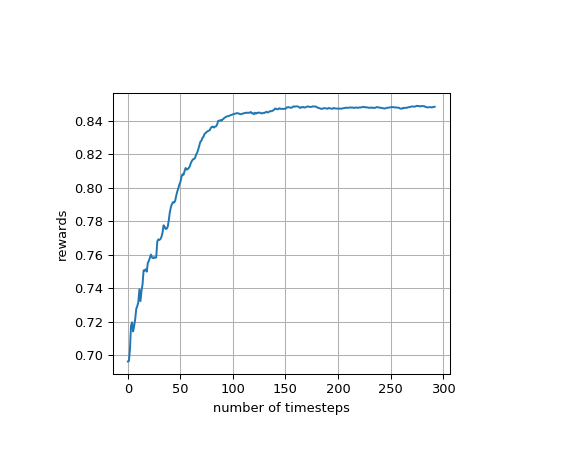

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.3, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.5],
                                episode_limit_array=[150000], 
                                log_dir=log_dir,
                                seed=seed)